In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/content/drive/My Drive/OIL_CrUDE/DCOILWTICO.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#Use the last available price to fill in missing data (since oil prices don’t change on closed days).
df["observation_date"] = pd.to_datetime(df["observation_date"])

df['DCOILWTICO'] = df['DCOILWTICO'].fillna(method='ffill')
df.head()

,observation_date,DCOILWTICO
0,2015-06-02,61.30
1,2015-06-03,59.67
2,2015-06-04,58.00
3,2015-06-05,59.11
4,2015-06-08,58.15


In [4]:
import pandas as pd
import yfinance as yf

crude = yf.download('CL=F', start='2015-06-02', end='2025-06-02')
crude.reset_index(inplace=True)

crude['Date'] = pd.to_datetime(crude['Date'])

crude.set_index('Date', inplace=True)





YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
!pip install mplfinance

In [5]:

crude = yf.download('CL=F', start='2015-06-02', end='2025-06-02')
crude.reset_index(inplace=True)

crude['Date'] = pd.to_datetime(crude['Date'])
crude.rename(columns={'Date': 'observation_date'}, inplace=True)

if isinstance(crude.columns, pd.MultiIndex):
    crude.columns = crude.columns.get_level_values(0)

df['observation_date'] = pd.to_datetime(df['observation_date'])
df = df.merge(crude[['observation_date', 'Volume']], on='observation_date', how='left')

df['Volume'] = df['Volume'].fillna(method='ffill')

[*********************100%***********************]  1 of 1 completed


In [7]:
!pip install ta

In [8]:
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.utils import dropna

df= dropna(df)

rsi = RSIIndicator(close=df["DCOILWTICO"])
df["RSI"] = rsi.rsi()

macd = MACD(close=df["DCOILWTICO"])
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()

df["MA10"] = df["DCOILWTICO"].rolling(window=10).mean()
df["MA50"] = df["DCOILWTICO"].rolling(window=50).mean()

bollinger = BollingerBands(close=df["DCOILWTICO"])
df["BB_High"] = bollinger.bollinger_hband()
df["BB_Low"] = bollinger.bollinger_lband()




In [9]:
df=df.drop(['MACD_Signal','MA50','BB_High','BB_Low'],axis=1)
df.head()

,observation_date,DCOILWTICO,Volume,RSI,MACD,MA10
0,2015-06-02,61.30,344508.0,NaN,NaN,NaN
1,2015-06-03,59.67,371298.0,NaN,NaN,NaN
2,2015-06-04,58.00,363345.0,NaN,NaN,NaN
3,2015-06-05,59.11,461016.0,NaN,NaN,NaN
4,2015-06-08,58.15,339845.0,NaN,NaN,NaN


# LSTM

In [10]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

features = [
    'DCOILWTICO', 'Volume', 'MA10', 'RSI', 'MACD'
]

df[features] = df[features].fillna(method='ffill')
df = df.dropna(subset=features)

train = df.iloc[:1950]
valid = df.iloc[1950:2300]
test = df.iloc[2300:]

scaler = MinMaxScaler()

train_data = scaler.fit_transform(train[features])
valid_data = scaler.transform(valid[features])
test_data = scaler.transform(test[features])

print("Train data shape:", train_data.shape)
print("Validation data shape:", valid_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (1950, 5)
Validation data shape: (350, 5)
Test data shape: (283, 5)


## Fine Tune Hyper parameteres

In [12]:
def create_sequences(data, seq_length, target_column_idx=None):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        if target_column_idx is None:
            y.append(data[i+seq_length])
        else:
            y.append(data[i+seq_length][target_column_idx])
    return np.array(X), np.array(y)


seq_length = 5
target_col = 0

X_train, y_train = create_sequences(train_data, seq_length, target_col)
X_val, y_val = create_sequences(valid_data, seq_length, target_col)
X_test, y_test = create_sequences(test_data, seq_length, target_col)

print(X_train.shape)
print(y_train.shape)

(1945, 5, 5)
(1945,)


In [16]:
! pip install optuna

In [21]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def create_model(trial, input_shape):
    model = Sequential()

    n_units1 = trial.suggest_int("n_units1", 64, 256)
    n_units2 = trial.suggest_int("n_units2", 32, 128)
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)

    model.add(Bidirectional(LSTM(n_units1, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(n_units2, return_sequences=False)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    optimizer = Adam(learning_rate=learning_rate) if optimizer_name == "Adam" else RMSprop(learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

def objective(trial):
    model = create_model(trial, input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # Return validation loss as the metric to minimize
    val_loss = min(history.history['val_loss'])
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial
print(f"  Loss: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-15 12:52:03,844] A new study created in memory with name: no-name-ad8a3a7a-32b4-4222-9a3f-1837452f7bdc
[I 2025-06-15 12:52:43,258] Trial 0 finished with value: 0.00020125183800701052 and parameters: {'n_units1': 158, 'n_units2': 65, 'dropout': 0.395394850840904, 'learning_rate': 0.003640138303712925, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.00020125183800701052.
[I 2025-06-15 12:52:55,453] Trial 1 finished with value: 0.00017612108786124736 and parameters: {'n_units1': 76, 'n_units2': 126, 'dropout': 0.3920115157105022, 'learning_rate': 0.0020269998069561254, 'optimizer': 'Adam', 'batch_size': 128}. Best is trial 1 with value: 0.00017612108786124736.
[I 2025-06-15 12:53:31,134] Trial 2 finished with value: 0.0008920605760067701 and parameters: {'n_units1': 93, 'n_units2': 80, 'dropout': 0.49191389221683873, 'learning_rate': 1.1160194861036054e-05, 'optimizer': 'Adam', 'batch_size': 128}. Best is trial 1 with value: 0.00017612108786124736.
[I 2025

Best trial:
  Loss: 0.0001122517860494554
  Params:
    n_units1: 142
    n_units2: 71
    dropout: 0.37887591262535264
    learning_rate: 0.0017616121186570944
    optimizer: Adam
    batch_size: 64


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

n_units1 = 142
n_units2 = 71
dropout_rate = 0.3789
learning_rate = 0.00176
batch_size = 64
optimizer_name = "Adam"

model = Sequential()
model.add(Bidirectional(LSTM(n_units1, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(n_units2, return_sequences=False)))
model.add(Dropout(dropout_rate))

model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.summary()

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 5, 284)         │       168,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 284)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 142)            │       202,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 142)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,945 (1.43 MB)

 Trainable params: 374,945 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - loss: 0.1133 - val_loss: 0.0028 - learning_rate: 0.0018
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0052 - val_loss: 3.9528e-04 - learning_rate: 0.0018
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0036 - val_loss: 8.0003e-04 - learning_rate: 0.0018
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0027 - val_loss: 7.9875e-04 - learning_rate: 0.0018
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0024 - val_loss: 2.6777e-04 - learning_rate: 0.0018
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0020 - val_loss: 4.8843e-04 - learning_rate: 0.0018
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0022 - val_loss: 1.9853e-04 - learning_rate: 0.0018
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0019
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0008800000068731606.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0019 - val_

In [23]:
train_predict = model.predict(X_train)
Val_predict = model.predict(X_val)
test_predict=model.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [14]:
model.save("lstm.h5")


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from math import sqrt

# -------- sMAPE Function --------
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# -------- MASE Function --------
def mase(y_true, y_pred):
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))  # naive lag-1 forecast
    return mae_model / mae_naive

# ----------- Train Metrics -----------
train_rmse = sqrt(mean_squared_error(y_train, train_predict))
train_mse = mean_squared_error(y_train, train_predict)
train_mae = mean_absolute_error(y_train, train_predict)
train_smape = smape(y_train, train_predict)
train_mase = mase(y_train, train_predict)
train_r2 = r2_score(y_train, train_predict)

# ----------- Validation Metrics -----------
val_rmse = sqrt(mean_squared_error(y_val, Val_predict))
val_mse = mean_squared_error(y_val, Val_predict)
val_mae = mean_absolute_error(y_val, Val_predict)
val_smape = smape(y_val, Val_predict)
val_mase = mase(y_val, Val_predict)
val_r2 = r2_score(y_val, Val_predict)

# ----------- Test Metrics -----------
test_rmse = sqrt(mean_squared_error(y_test, test_predict))
test_mse = mean_squared_error(y_test, test_predict)
test_mae = mean_absolute_error(y_test, test_predict)
test_smape = smape(y_test, test_predict)
test_mase = mase(y_test, test_predict)
test_r2 = r2_score(y_test, test_predict)

# ---------- Print All ----------
print("======== Train Metrics ========")
print(f"Train RMSE: {train_rmse}")
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Train sMAPE: {train_smape:.2f}%")
print(f"Train MASE: {train_mase:.3f}")
print(f"Train R² Score: {train_r2:.4f}")

print("\n======== Validation Metrics ========")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MSE: {val_mse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation sMAPE: {val_smape:.2f}%")
print(f"Validation MASE: {val_mase:.3f}")
print(f"Validation R² Score: {val_r2:.4f}")

print("\n======== Test Metrics ========")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test sMAPE: {test_smape:.2f}%")
print(f"Test MASE: {test_mase:.3f}")
print(f"Test R² Score: {test_r2:.4f}")


======== Train Metrics ========
Train RMSE: 0.018889880533778828
Train MSE: 0.00035682758658043623
Train MAE: 0.012594045742580787
Train sMAPE: 20.51%
Train MASE: 18.119
Train R² Score: 0.9746

======== Validation Metrics ========
Validation RMSE: 0.013734568130086462
Validation MSE: 0.00018863836171998673
Validation MAE: 0.01085284502551401
Validation sMAPE: 5.61%
Validation MASE: 5.477
Validation R² Score: 0.8544

======== Test Metrics ========
Test RMSE: 0.012347151712374696
Test MSE: 0.00015245215540839738
Test MAE: 0.009601637282520177
Test sMAPE: 6.31%
Test MASE: 6.447
Test R² Score: 0.8993


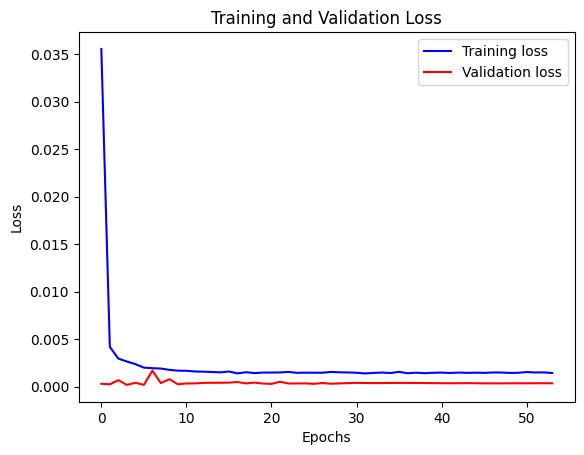

In [26]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



In [27]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


target_col = 0

scaler_y = MinMaxScaler()
scaler_y.fit(train_data[:, target_col].reshape(-1, 1))

y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))

train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))

val_predict_inv = scaler_y.inverse_transform(Val_predict)
y_val_inv = scaler_y.inverse_transform(y_val.reshape(-1, 1))


y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))



test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))


Train dates vs y_train_inv: 1945 1945
Val dates vs y_val_inv: 345 345
Test dates vs y_test_inv: 278 278


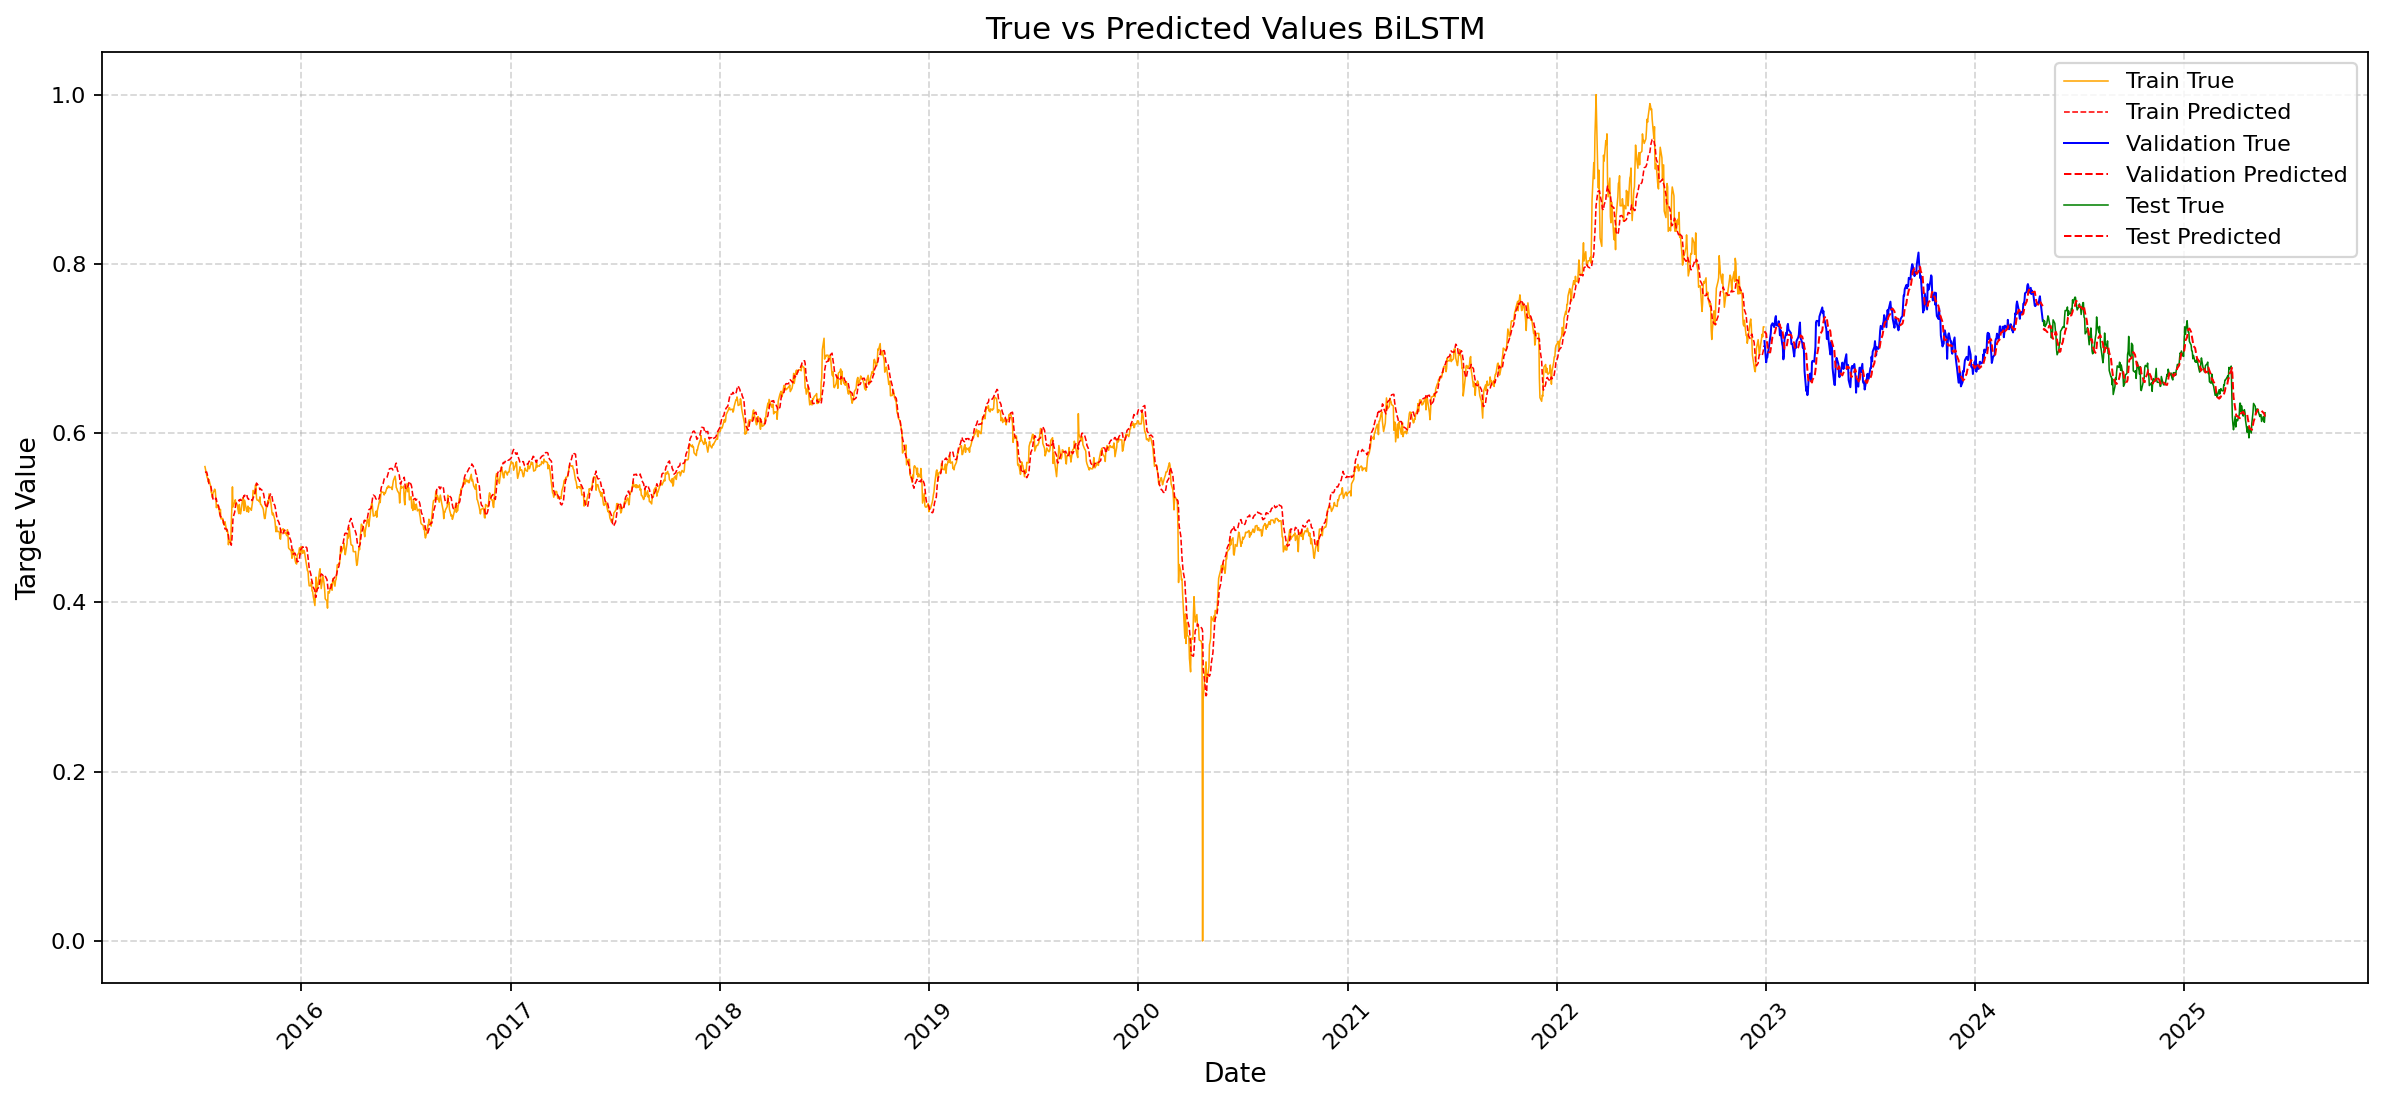

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df['observation_date'] = pd.to_datetime(df['observation_date'])

seq_length = 8

train_len = len(y_train_inv)
val_len = len(y_val_inv)
test_len = len(y_test_inv)

total_y = train_len + val_len + test_len

adjusted_dates = df['observation_date'].values[seq_length: seq_length + total_y]

train_dates = adjusted_dates[:train_len]
val_dates = adjusted_dates[train_len:train_len + val_len]
test_dates = adjusted_dates[train_len + val_len:]

print("Train dates vs y_train_inv:", len(train_dates), len(y_train_inv))
print("Val dates vs y_val_inv:", len(val_dates), len(y_val_inv))
print("Test dates vs y_test_inv:", len(test_dates), len(y_test_inv))

y_train_inv = y_train_inv.flatten()
train_predict_inv = train_predict_inv.flatten()
y_val_inv = y_val_inv.flatten()
val_predict_inv = val_predict_inv.flatten()
y_test_inv = y_test_inv.flatten()
test_predict_inv = test_predict_inv.flatten()

plt.figure(figsize=(15, 7), dpi=160)

plt.plot(train_dates, y_train_inv, label='Train True', color='orange', linewidth=0.7)
plt.plot(train_dates, train_predict_inv, label='Train Predicted', linestyle='--', color='red', linewidth=0.7)

plt.plot(val_dates, y_val_inv, label='Validation True', color='blue', linewidth=0.9)
plt.plot(val_dates, val_predict_inv, label='Validation Predicted', linestyle='--', color='red', linewidth=0.9)

plt.plot(test_dates, y_test_inv, label='Test True', color='green', linewidth=0.7)
plt.plot(test_dates, test_predict_inv, label='Test Predicted', linestyle='--', color='red', linewidth=0.9)

plt.title('True vs Predicted Values BiLSTM', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
